In [1]:
# JAI SHREE KRISHNA...
!pip install wfdb
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 13.8 MB/s eta 0:00:0000:01


## ⚙️ Project Pipeline: Step-by-Step

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from PIL import Image
import wfdb
from wfdb import processing 
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy import signal
import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight 

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

os.makedirs('mit-bih-data', exist_ok=True)

2025-11-02 09:26:01.513027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762075561.732450      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762075561.829608      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

print("Downloading MIT-BIH Arrhythmia Database...")
wfdb.dl_database('mitdb', 'mit-bih-data')
print("Download complete.")

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [4]:

label_map = {
    'N': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,  
    'V': 1, 'E': 1,                         
    'S': 2, 'A': 2, 'a': 2, 'J': 2          
}
valid_symbols = list(label_map.keys())
N_CLASSES = len(np.unique(list(label_map.values())))
class_names = ['Normal', 'Ventricular', 'Supraventricular']
print(f"We will classify {N_CLASSES} classes: {class_names}")


IMG_SIZE = 128
# base_dir = 'spectrograms_dataset_cropped'
base_dir = 'spectrograms_dataset_cropped' 
MAX_FREQ_HZ = 45 

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = filtfilt(b, a, data)
    return y

def save_segment_as_image(segment, fs=360, save_path=None):
    """ Converts 1D segment to a cropped 2D spectrogram and saves it. """
    f, t, Sxx = signal.spectrogram(segment, fs=fs, nperseg=128, noverlap=64)
    
 
    freq_slice_index = np.where(f > MAX_FREQ_HZ)[0]
    if len(freq_slice_index) > 0:
        Sxx = Sxx[:freq_slice_index[0], :]
   

    log_Sxx = np.log1p(Sxx)
    norm_min = np.min(log_Sxx)
    norm_max = np.max(log_Sxx)
    norm_Sxx = (log_Sxx - norm_min) / (norm_max - norm_min + 1e-6)
    img_array = (norm_Sxx * 255).astype(np.uint8)
    img = Image.fromarray(img_array).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
    img.save(save_path, 'PNG')


print(f"Saving images to: {base_dir}")
for set_name in ['train', 'val', 'test']:
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, set_name, class_name), exist_ok=True)


def process_records_and_save_images(record_list, set_name, data_dir='mit-bih-data'):
    """ Loads ONE record, processes it, and saves cropped spectrograms. """
    fs = 360
    window_samples = int(2 * fs) # 2-second window
    total_segments_saved = 0
    print(f"\nProcessing {len(record_list)} records for '{set_name}' set...")
    
    for i, record_name in enumerate(record_list):
        print(f"  Record {i+1}/{len(record_list)}: {record_name}")
        record_segments_saved = 0
        try:
            record = wfdb.rdrecord(os.path.join(data_dir, record_name))
            annotation = wfdb.rdann(os.path.join(data_dir, record_name), 'atr')
            signal_data = record.p_signal[:, 0]
            signal_filtered = bandpass_filter(signal_data, lowcut=0.5, highcut=40.0, signal_freq=fs, filter_order=1)
            
            try:
                r_peaks = processing.gqrs_detect(sig=signal_filtered, fs=fs)
            except Exception:
                _, rpeaks_dict = nk.ecg_peaks(signal_filtered, sampling_rate=fs)
                r_peaks = rpeaks_dict['ECG_R_Peaks']

            if len(r_peaks) == 0:
                print(f"    No R-peaks found. Skipping.")
                continue

            symbols = annotation.symbol
            symbol_locations = annotation.sample
            
            for r_peak in r_peaks:
                closest_ann_idx = np.argmin(np.abs(symbol_locations - r_peak))
                if symbols[closest_ann_idx] in valid_symbols:
                    half_window = window_samples // 2
                    if r_peak - half_window < 0 or r_peak + half_window > len(signal_filtered):
                        continue
                    
                    segment = signal_filtered[r_peak - half_window : r_peak + half_window]
                    segment_normalized = MinMaxScaler().fit_transform(segment.reshape(-1, 1)).flatten()
                    label = label_map[symbols[closest_ann_idx]]
                    class_name = class_names[label]
                    file_name = f"{record_name}_{record_segments_saved:05d}.png"
                    save_path = os.path.join(base_dir, set_name, class_name, file_name)
                    save_segment_as_image(segment_normalized, fs=fs, save_path=save_path)
                    record_segments_saved += 1
            
            print(f"    Saved {record_segments_saved} segments.")
            total_segments_saved += record_segments_saved
        except Exception as e:
            print(f"    ERROR processing record {record_name}: {e}")
        del record, annotation, signal_data, signal_filtered, r_peaks
        gc.collect() 
    print(f"\nFinished '{set_name}' set. Total segments saved: {total_segments_saved}")


all_records = sorted(list(set([f.split('.')[0] for f in os.listdir('mit-bih-data') if f.endswith('.dat')])))
train_records, test_val_records = train_test_split(all_records, test_size=0.3, random_state=42)
val_records, test_records = train_test_split(test_val_records, test_size=0.5, random_state=42)
print(f"Total records: {len(all_records)} | Train: {len(train_records)} | Val: {len(val_records)} | Test: {len(test_records)}")


process_records_and_save_images(train_records, 'train')
process_records_and_save_images(val_records, 'val')
process_records_and_save_images(test_records, 'test')
print("\nAll processing and CROPPED image saving complete.")

We will classify 3 classes: ['Normal', 'Ventricular', 'Supraventricular']
Saving images to: spectrograms_dataset_cropped
Total records: 48 | Train: 33 | Val: 7 | Test: 8

Processing 33 records for 'train' set...
  Record 1/33: 114
    Saved 1871 segments.
  Record 2/33: 118
    Saved 2283 segments.
  Record 3/33: 232
    Saved 1794 segments.
  Record 4/33: 116
    Saved 2399 segments.
  Record 5/33: 109
    Saved 2526 segments.
  Record 6/33: 117
    Saved 1533 segments.
  Record 7/33: 208
    Saved 2569 segments.
  Record 8/33: 212
    Saved 2746 segments.
  Record 9/33: 233
    Saved 3063 segments.
  Record 10/33: 100
    Saved 2269 segments.
  Record 11/33: 210
    Saved 2633 segments.
  Record 12/33: 209
    Saved 3003 segments.
  Record 13/33: 105
    Saved 2614 segments.
  Record 14/33: 112
    Saved 2539 segments.
  Record 15/33: 214
    Saved 2257 segments.
  Record 16/33: 101
    Saved 1861 segments.
  Record 17/33: 231
    Saved 1569 segments.
  Record 18/33: 123
    Saved 15

In [5]:

BATCH_SIZE = 64
N_CHANNELS = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


print("Creating training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE
)

print("Creating validation dataset...")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

print("Creating test dataset...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names_from_generator = train_dataset.class_names
print(f"Classes found by the generator: {class_names_from_generator}")


print("Calculating class weights...")


train_labels = []

for images, labels in train_dataset:
    train_labels.extend(np.argmax(labels.numpy(), axis=1))

print(f"Found {len(train_labels)} total training samples.")


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))

print(f"Calculated Class Weights: {class_weight_dict}")
print("Class '0' (Normal) will be weighted lightly.")
print("Classes '1' and '2' (arrhythmias) will be weighted heavily.")


print("Applying performance optimizations (prefetching only)...")
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Done. You can now run the next cell.")

Creating training dataset...
Found 69038 files belonging to 3 classes.


I0000 00:00:1762076260.098822      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762076260.099489      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Creating validation dataset...
Found 14673 files belonging to 3 classes.
Creating test dataset...
Found 17037 files belonging to 3 classes.
Classes found by the generator: ['Normal', 'Supraventricular', 'Ventricular']
Calculating class weights...
Found 69038 total training samples.
Calculated Class Weights: {0: 0.3746831870702334, 1: 9.821880779627259, 2: 4.361763962597927}
Class '0' (Normal) will be weighted lightly.
Classes '1' and '2' (arrhythmias) will be weighted heavily.
Applying performance optimizations (prefetching only)...
Done. You can now run the next cell.


In [6]:

def build_lightweight_cnn(input_shape, num_classes):
    """Builds a custom 4-layer CNN with a Rescaling layer."""
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    # Classifier Head
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
model = build_lightweight_cnn(input_shape, N_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,963 (16.36 MB)

 Trainable params: 4,288,515 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:

checkpoint_cb = ModelCheckpoint("best_model.keras",
                                save_best_only=True,
                                monitor='val_loss', # Monitor val_loss is often better
                                mode='min',
                                verbose=1)

early_stopping_cb = EarlyStopping(monitor='val_loss',
                                  patience=10, # Wait 10 epochs for val_loss to improve
                                  restore_best_weights=True,
                                  verbose=1)

EPOCHS = 50

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
    
    class_weight=class_weight_dict,
    # ------------------------------------------ 
    verbose=1
)

Epoch 1/50


I0000 00:00:1762076279.104978     130 service.cc:148] XLA service 0x7ad18800edd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762076279.106474     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762076279.106495     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762076279.679967     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1079 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.4609 - loss: 2.1320   

I0000 00:00:1762076284.889194     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1079/1079 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8899 - loss: 0.4093
Epoch 1: val_loss improved from inf to 0.67832, saving model to best_model.keras
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.8900 - loss: 0.4091 - val_accuracy: 0.8160 - val_loss: 0.6783
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9556 - loss: 0.1565
Epoch 2: val_loss did not improve from 0.67832
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.9556 - loss: 0.1565 - val_accuracy: 0.7457 - val_loss: 0.9707
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9642 - loss: 0.1366
Epoch 3: val_loss did not improve from 0.67832
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - accuracy: 0.9642 - loss: 0.1366 - val_accuracy: 0.8213 - val_loss: 0.7449
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9711 - loss: 0.1028
Epoch 4: val_loss did not improve from 0.67832
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9711 - loss

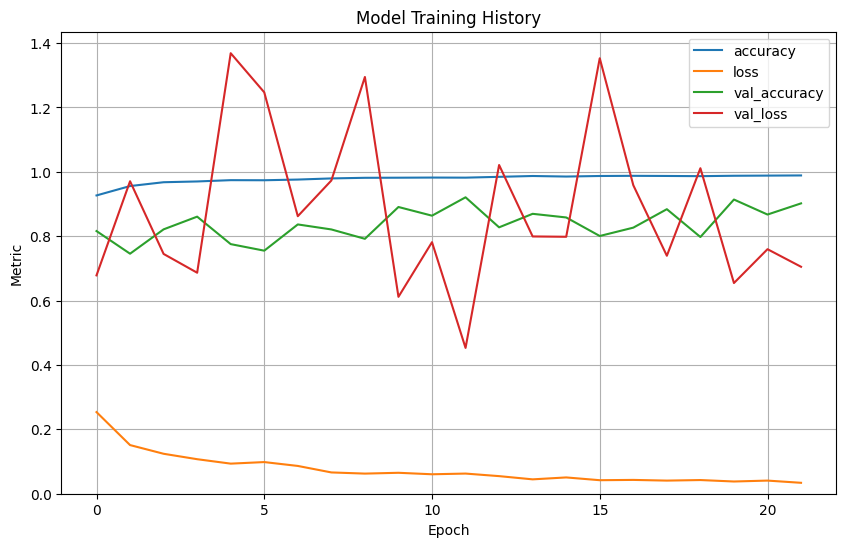

Evaluating model on test set...
Test Loss:     0.5227
Test Accuracy: 0.8618

Generating classification report and confusion matrix...
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Found 17037 true labels and 17037 predictions.

--- Classification Report ---
                  precision    recall  f1-score   support

          Normal       0.99      0.86      0.92     15782
Supraventricular       0.11      0.65      0.18       277
     Ventricular       0.56      0.93      0.70       978

        accuracy                           0.86     17037
       macro avg       0.55      0.81      0.60     17037
    weighted avg       0.95      0.86      0.90     17037


--- Confusion Matrix ---


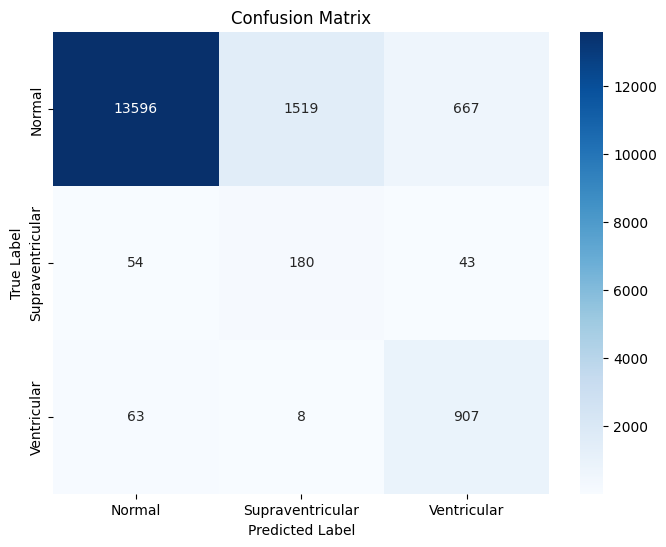

In [8]:

pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.title("Model Training History")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.grid(True)
plt.ylim(0, plt.ylim()[1]) # Adjust y-axis
plt.show()

print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nGenerating classification report and confusion matrix...")

y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true_categorical = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true_categorical, axis=1)

print(f"Found {len(y_true)} true labels and {len(y_pred)} predictions.")

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names_from_generator))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_from_generator, yticklabels=class_names_from_generator)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Using last conv layer: conv2d_2

Generating Grad-CAM visualizations...


/tmp/ipykernel_37/3757242618.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


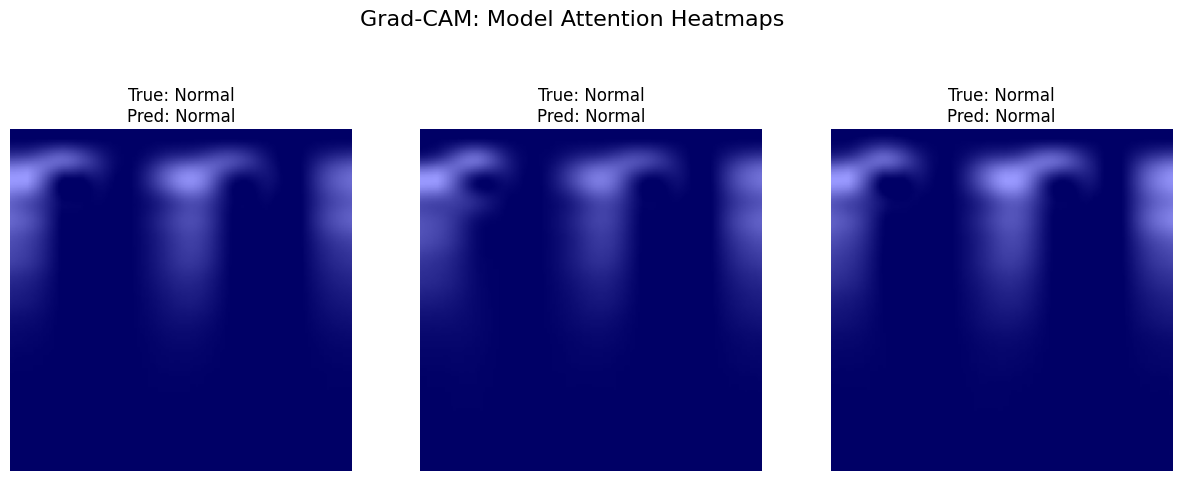

In [11]:

def make_gradcam_heatmap(img_array_batch, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array_batch)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(img_array_normalized, heatmap, alpha=0.4):
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img_array_normalized.shape[0], img_array_normalized.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap.squeeze()]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array_normalized.shape[1], img_array_normalized.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + (img_array_normalized * 255.) * (1 - alpha)
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    return superimposed_img

last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break
print(f"Using last conv layer: {last_conv_layer_name}")

print("\nGenerating Grad-CAM visualizations...")

# Get a batch of test images
images, labels = next(iter(test_dataset))

plt.figure(figsize=(15, 6))

for i in range(3):
    img = images[i]
    img_batch = np.expand_dims(img, axis=0)
    
    label_categorical = labels[i]
    true_class_idx = np.argmax(label_categorical)
    true_class_name = class_names_from_generator[true_class_idx]
    
    pred_probs = model.predict(img_batch, verbose=0)[0]
    pred_class_idx = np.argmax(pred_probs)
    pred_class_name = class_names_from_generator[pred_class_idx]

    heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name, pred_index=pred_class_idx)
    
    img_normalized_for_display = img.numpy().astype("float32") / 255.0
    
    superimposed_img = display_gradcam(img_normalized_for_display, heatmap)
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(superimposed_img)
    plt.title(f"True: {true_class_name}\nPred: {pred_class_name}")
    plt.axis('off')

plt.suptitle("Grad-CAM: Model Attention Heatmaps", fontsize=16)
plt.show()